In [1]:
import autograd.numpy as np

import matplotlib.pyplot as plt
from ipywidgets import *

import circle
from distance_utils import *
from mrf import rf, rf_weights, rf_par, rf_kmeans
from nw import nw_weights, epanechnikov, gaussian

%load_ext autoreload
%autoreload 2

In [2]:
def gen_data(N, eps=0.1, d=3):
    assert d >= 3
    x = np.random.rand(N*d).reshape((N,d))
    m = lambda x: 5 + 5*x[:,0]**2 + np.sin(20 * x[:,1]) - 10*x[:,2]**3 

    theta = m(x) + eps*np.random.randn(N)
    y = np.c_[np.cos(theta), np.sin(theta)]
    return x, y


# It seems that t
# - the NW estimator is better than RF for d=1 (in the simple model)
# - for d=3 (=true d) the random forest is slightly better
# - for d large (true d=3), the random forest is much better

N = 200; eps = 0.5; d=10
x_train, y_train = gen_data(N, eps, d)
x_test, y_test = gen_data(100, eps, d)
theta_train = circle.r2_to_angle(y_train)
theta_test = circle.r2_to_angle(y_test)

ValueError: x and y must be the same size

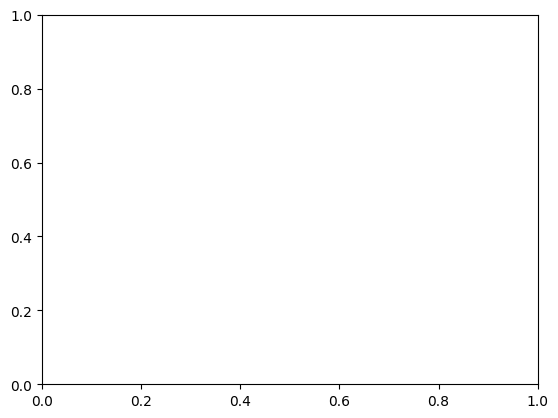

In [3]:
%matplotlib inline
plt.scatter(x_train, theta_train, s=1,label="Y_i")
plt.plot(np.linspace(0,1,100), m(np.linspace(0,1,100)), c='black', linestyle='--', label='m(x)', alpha=0.1)
plt.legend()

In [3]:
%%time

D = D_mat_sq_par(circle.d, y_train)

# Observations:
#     - Experiment with s < 0.5*N had not great results because weights are not local enough
#     - Works well with small data as long as s is large enough
#     - s has the most influence on speed
# forest = rf(1000, x_train, D, 250)
forest = rf_par(500, x_train, D, 150)

preds = np.zeros((2, x_test.shape[0], 2))
for i in range(x_test.shape[0]):
    preds[0,i,:] = circle.frechet_mean(y_train, rf_weights(forest, x_test[i,:]))
    preds[1,i,:] = circle.frechet_mean(y_train, nw_weights(x_test[i,:], x_train, gaussian, 0.02))

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-2)]: Done 500 out of 500 | elapsed:   16.2s finished
/Users/matthieubulte/Documents/university/phd/merf/nw.py:11: RuntimeWarning: invalid value encountered in divide
  return w / w.sum()
/Users/matthieubulte/.pyenv/versions/3.9.16/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:86: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.arccos, lambda ans, x : lambda g:-g / anp.sqrt(1 - x**2))


CPU times: user 3.21 s, sys: 260 ms, total: 3.47 s
Wall time: 19.9 s


In [ ]:
rf_kmeans(500, )

array([1.28710798, 2.47489402])

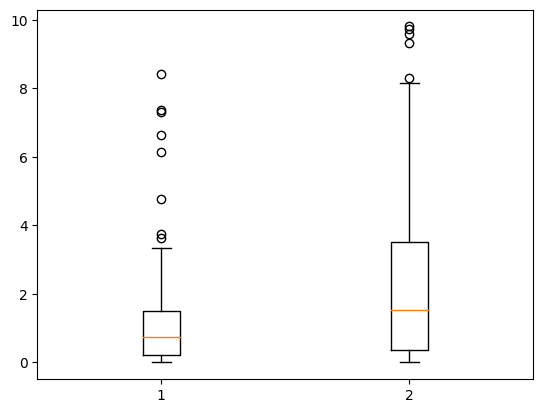

In [8]:
%matplotlib inline
errs = np.zeros((2, x_test.shape[0]))
for i in range(x_test.shape[0]):
    errs[0,i] = circle.d(y_test[i], preds[0,i,:])
    errs[1,i] = circle.d(y_test[i], preds[1,i,:])

plt.boxplot(errs[:,~np.isnan(errs[1,:])].T)

errs[:,~np.isnan(errs[1,:])].mean(axis=1)

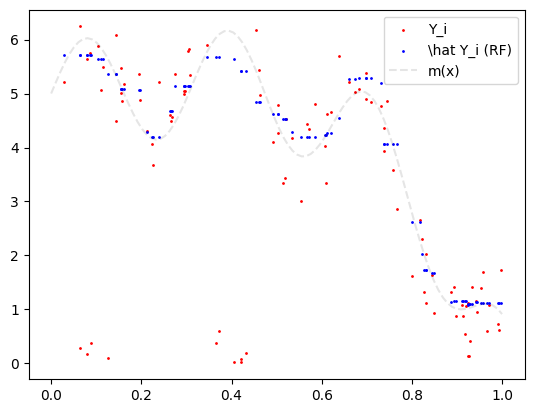

In [132]:
%matplotlib inline

preds_angles = circle.r2_to_angle(preds[0,:,:])
theta_test = circle.r2_to_angle(y_test)

plt.scatter(x_test, theta_test, c='red',s=1,label="Y_i")
plt.scatter(x_test, preds_angles, c='blue',s=1,label="\\hat Y_i (RF)")
plt.plot(np.linspace(0,1,100), m(np.linspace(0,1,100)), c='black', linestyle='--', label='m(x)', alpha=0.1)
plt.legend()

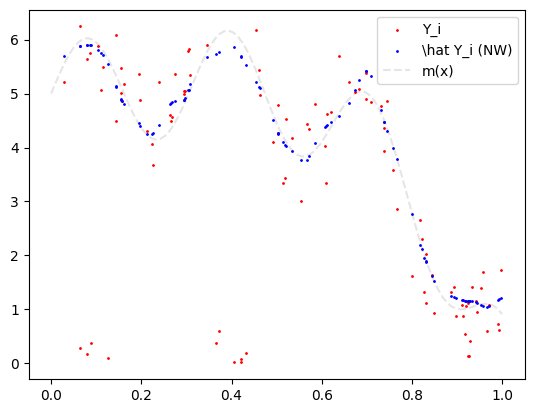

In [133]:
%matplotlib inline

preds_angles = circle.r2_to_angle(preds[1,:,:])
theta_test = circle.r2_to_angle(y_test)

plt.scatter(x_test, theta_test, c='red',s=1,label="Y_i")
plt.scatter(x_test, preds_angles, c='blue',s=1,label="\\hat Y_i (NW)")
plt.plot(np.linspace(0,1,100), m(np.linspace(0,1,100)), c='black', linestyle='--', label='m(x)', alpha=0.1)
plt.legend()

<IPython.core.display.Javascript object>


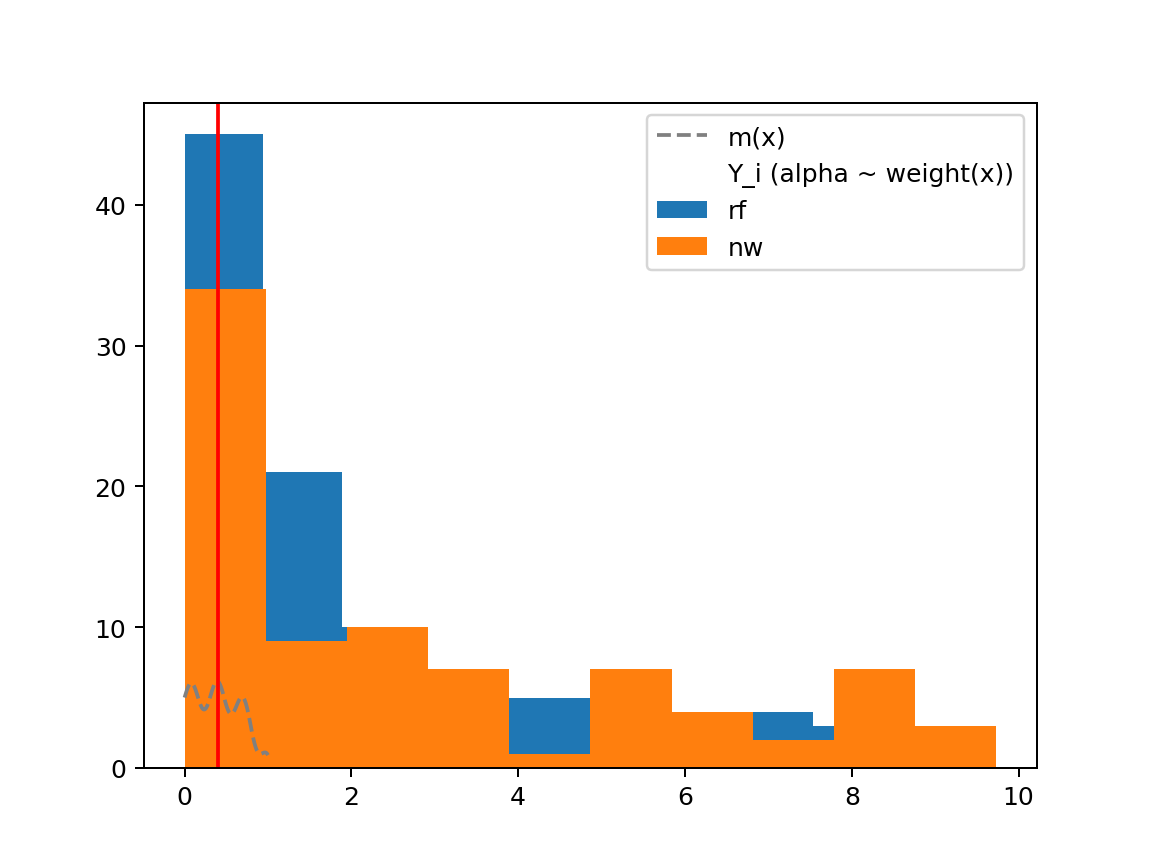

interactive(children=(FloatSlider(value=0.5, description='_x', max=1.5, min=-0.5), Output()), _dom_classes=('w…

In [135]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
weights = rf_weights(forest, [0.5])
ax.plot(np.linspace(0,1,100), m(np.linspace(0,1,100)), c='gray', linestyle='--', label='m(x)')
scat = ax.scatter(x_train, theta_train, label='Y_i (alpha ~ weight(x))')
eval_pt = ax.axvline(0.5, c='red')
ax.legend()

def update(_x = 0.5):
#     weights = rf_weights(forest, [_x])
#     scat.set_alpha(weights)
    weights = nw_weights([_x], x_train, gaussian, 0.02)
    scat.set_alpha(weights)
    eval_pt.set_xdata(_x)
    fig.canvas.draw_idle()

interact(update);